# Modelagem de Tópicos

##Julho 2019
###MBA Executivo em Business Analytics e Big Data
###Aluno: Christian Torturella Vidal



### Importando bibliotecas a serem usadas

In [1]:
install.packages("topicmodels")
install.packages('SnowballC')
install.packages('tidytext')
install.packages("LDAvis")
install.packages("tsne")
install.packages("RCurl")
install.packages("xml2")
install.packages("wordcloud")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘NLP’, ‘modeltools’, ‘slam’, ‘tm’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘ISOcodes’, ‘hunspell’, ‘tokenizers’, ‘janeaustenr’, ‘stopwords’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘proxy’, ‘RJSONIO’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘bitops’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
suppressMessages(suppressWarnings(library(topicmodels)))
suppressMessages(suppressWarnings(library(tm)))
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(SnowballC)))
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(tidyr)))
suppressMessages(suppressWarnings(library(plyr)))
suppressMessages(suppressWarnings(library(reshape2)))
suppressMessages(suppressWarnings(library(ggplot2)))
suppressMessages(suppressWarnings(library(tidytext)))
suppressMessages(suppressWarnings(library(LDAvis)))
suppressMessages(suppressWarnings(library(RCurl)))
suppressMessages(suppressWarnings(library(xml2)))
suppressMessages(suppressWarnings(library(wordcloud)))

### Download dos dados
Importe aqui seu dataset de texto.

Será realizada uma captura das notícias do G1 através da leitura e tratamento dos RSS disponibilizados pela própria plataforma.

Este ponto é interessante pois já fornece através de diferentes URLs, as categorias de notícia que servirão para a validação da modelagem realizada.

In [0]:
#Criando uma função de captura e tratamento do xml RSS
getDadosRss <- function(url,fonte) {
  
    doc <- read_xml(url)
  
    feed_title    <- xml_text(xml_find_all(doc,'//channel/title'))
    feed_link    <- xml_text(xml_find_all(doc,'//channel/link'))
    item_titles    <- xml_text(xml_find_all(doc,'//item/title'))
    item_description    <- xml_text(xml_find_all(doc,'//item/description'))
    item_link    <- xml_text(xml_find_all(doc,'//item/link'))
    item_data_published <- xml_text(xml_find_all(doc,'//item/pubDate'))
    item_category <- xml_text(xml_find_all(doc,'//item/category'))

    doc <- data.frame(feed_title=feed_title,feed_link=feed_link,item_titles=item_titles,
                       item_description=item_description,item_data_published=item_data_published,item_link=item_link,
                       item_category=item_category)
  
    # Removendo noticias que são chamadas para outras páginas
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^VÍDEOS:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^VÍDEO:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^AO VIVO:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^Assista ao Jornal"))

    # Removendo link das imagens
    doc$item_description <- str_replace_all(doc$item_description, "<img\\ssrc.*/>","")

    # Removendo sentenças comuns a todos os textos
    remove_sentences <- function(x) {
      x <- str_replace_all(x,"Tem alguma notícia para compartilhar[?]","")
      x <- str_replace_all(x,"Envie para o Tô Na Rede!","")
      x <- str_replace_all(x,'"',"'")
      x <- str_replace_all(x,"‘","'")
      x <- str_replace_all(x,"’","'")
      x <- str_replace_all(x,"“","'")
      x <- str_replace_all(x,"”","'")
      x <- str_trim(x)
    }
  
    doc$fonte <- fonte
   
    doc$index <- seq(1:nrow(doc))
  
    doc$item_description <- lapply(doc$item_description,remove_sentences)
  
    doc$text <- paste0(doc$item_titles," ",doc$item_description)
  
    doc$document <- paste0(doc$fonte,"_",doc$index)
  
    doc
}

#Capturando notícias do G1 através da leitura de RSS
options(warn=-1)
dados <- getDadosRss("http://g1.globo.com/dynamo/politica/mensalao/rss2.xml","Fonte:Política")
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/educacao/rss2.xml","Fonte:Educação"))
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/ciencia-e-saude/rss2.xml","Fonte:Ciência e Saúde"))
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/natureza/rss2.xml","Fonte:Natureza"))
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/tecnologia/rss2.xml","Fonte:Tecnologia"))

dados_final <- dados %>% select(document,text)


In [4]:
head(dados_final)

document        
1 Fonte:Política_1
2 Fonte:Política_2
3 Fonte:Política_3
4 Fonte:Política_4
5 Fonte:Política_5
6 Fonte:Política_6
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Transforme seus dados em um corpus
Corpus é um conjunto de textos. Nesse contexto, corpus é o objeto da biblioteca tm criado para tratar os textos. 

In [39]:
source <- VectorSource(dados_final$text)
corpus <- Corpus(source)
corpus

inspect(corpus[1:length(corpus)])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 188

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Qual a quantidade de documentos no seu corpus?

Neste exemplo e capturando as notícias fornecidas pelo G1 no instante de execução do script, temos um total de documentos igual a:


In [40]:
length(corpus)

[1] 188

### Preprocessando os dados
Realize aqui os pré-processamentos que você julgar necessário nesse corpus. **Explique suas escolhas.**

In [70]:
#Adotaremos como premissa que as informações contidas nos documentos são case insensitive
corpus <- tm_map(corpus, content_transformer(tolower))
#Outro ponto é a não consideração dos números pois em várias notícias estão citadas datas e valores que não são importantes para a definição do tópico em si
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removePunctuation)
#Foram acrescentadas algumas stopwords adicionais depois de desenvolvida a primeira análise pois estavam distorcendo as métricas e não representando um
#ponto importante para a definição dos tópicos
stop_words <- c("segundo","ser","ainda","€","'","-","ª","ºc","º","mil","nº","dia","dias","ano","anos","disse","\"","r","g"," – ","após","deve","hoje","uso","caso",
                "dois","três","quatro","cinco","seis","sete","oito","nove","dez","segundafeira","terçafeira","quartafeira","quintafeira","sábado","domingo","então",
                "neste","podem","pode","acordo","durante","onde","deste","sobre","diz","ter","vai","nesta","fazer","além","outros","apenas","desde","disso","sido","agora",
                "sendo","porque","junho","julho","menos","outras","maior","cada","têm","forma","alguns","algum","parte","afirmou","vez","veja","todos","cerca","antes","todo","outro")
corpus <- tm_map(corpus, removeWords, c(stop_words,stopwords('portuguese'),stopwords('english')))
#Retirando os espaços
corpus <- tm_map(corpus, stripWhitespace)

inspect(corpus[1:10])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 10

 [1] stf perdoa pena condenados mensalão pt base indulto temer exsócios marcos valério publicitários cristiano paz ramon hollerbach penas privativas liberdade perdoadas ministro luís roberto barroso indulto temer dá perdão pena condenados mensalão lava jato ministro luís roberto barroso supremo tribunal federal stf perdoou pena condenados julgamento mensalão pt base indulto natalino editado presidente república michel temer exsócios empresário marcos valério cristiano paz ramon hollerbach extintas penas privativas liberdade continuam obrigação pagar multa imposta suprema corte publicitário ramon hollerbach condenado julgamento mensalão pt meses prisão crimes corrupção ativa evasão divisas lavagem dinheiro peculato condenado meses reclusão cristiano paz é publicitário acusado procuradoriageral república pgr atuar obtenção empréstimos fraudulentos alimentavam esquema mensalão pt paz fundo

### Crie sua matriz termo-documento. Quantos termos você possui no seu vocabulário?

In [0]:
#Utilizando o peso TF
mat <- DocumentTermMatrix(corpus,control = list(weighting=weightTf))


In [72]:
#Verificando a dimensão (dados esparsos)
dim(mat)

mat_nosparse <- removeSparseTerms(mat, 0.99)

dim(as.matrix(mat_nosparse))

wordcount <- colSums(as.matrix(mat_nosparse))
topten <- head(sort(wordcount, decreasing=TRUE), 10)

[1]   188 14172

[1]  188 5990

Verificando a frequência das palavras dentro do corpus:

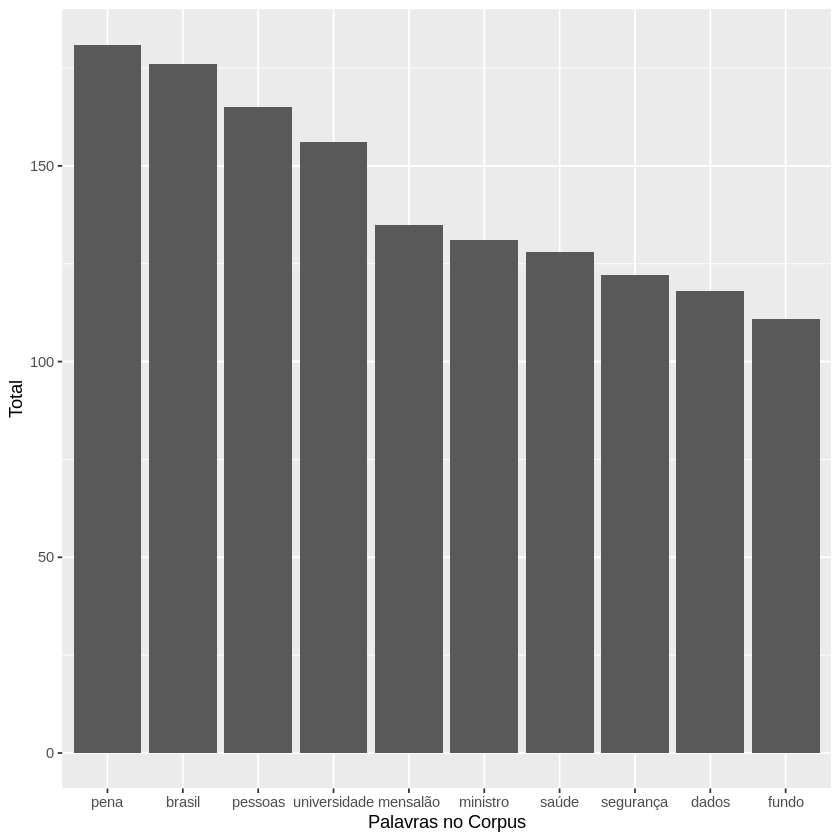

In [73]:
dfplot <- as.data.frame(melt(topten))
dfplot$word <- dimnames(dfplot)[[1]]
dfplot$word <- factor(dfplot$word,
                      levels=dfplot$word[order(dfplot$value,
                                               decreasing=TRUE)])

fig <- ggplot(dfplot, aes(x=word, y=value)) + geom_bar(stat="identity")
fig <- fig + xlab("Palavras no Corpus")
fig <- fig + ylab("Total")
print(fig)

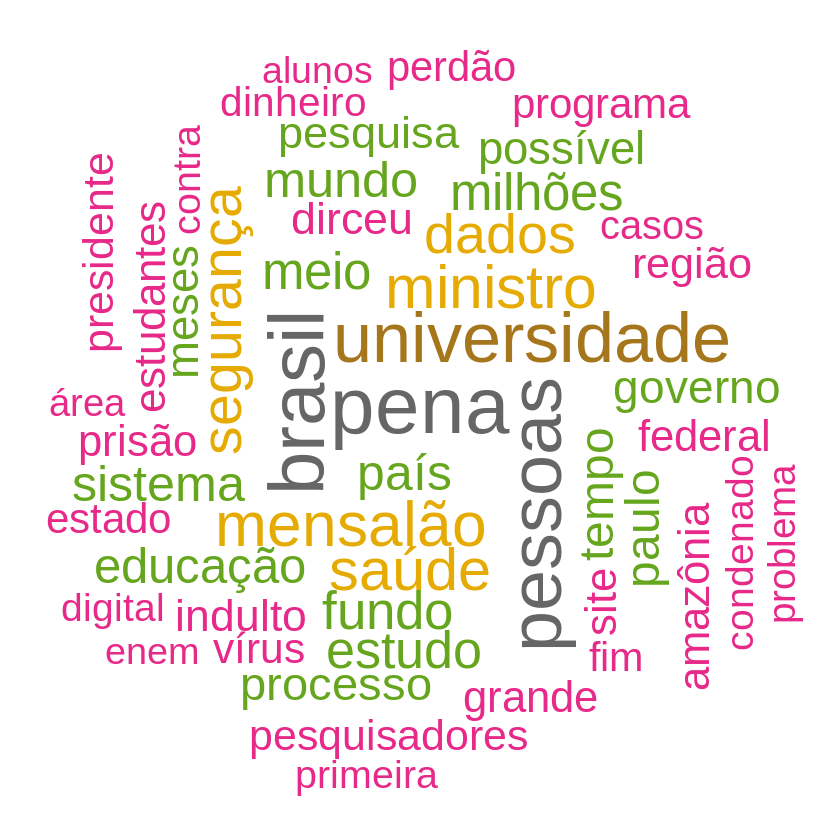

In [74]:
#Gerando a nuvem de palavras para melhor visualização das frequênciaximportância
freq = data.frame(sort(colSums(as.matrix(mat_nosparse)), decreasing=TRUE))

wordcloud(rownames(freq), freq[,1], min.freq = 1,max.words=50, random.order=FALSE, 
          rot.per=0.25,colors=brewer.pal(8, "Dark2"))

###A matriz termo-documento possui um total de termos igual a:


In [75]:
dim(mat_nosparse)[2]

[1] 5990

### Descubra o número de tópicos no seu documento. Justifique cada passa e a sua escolha.

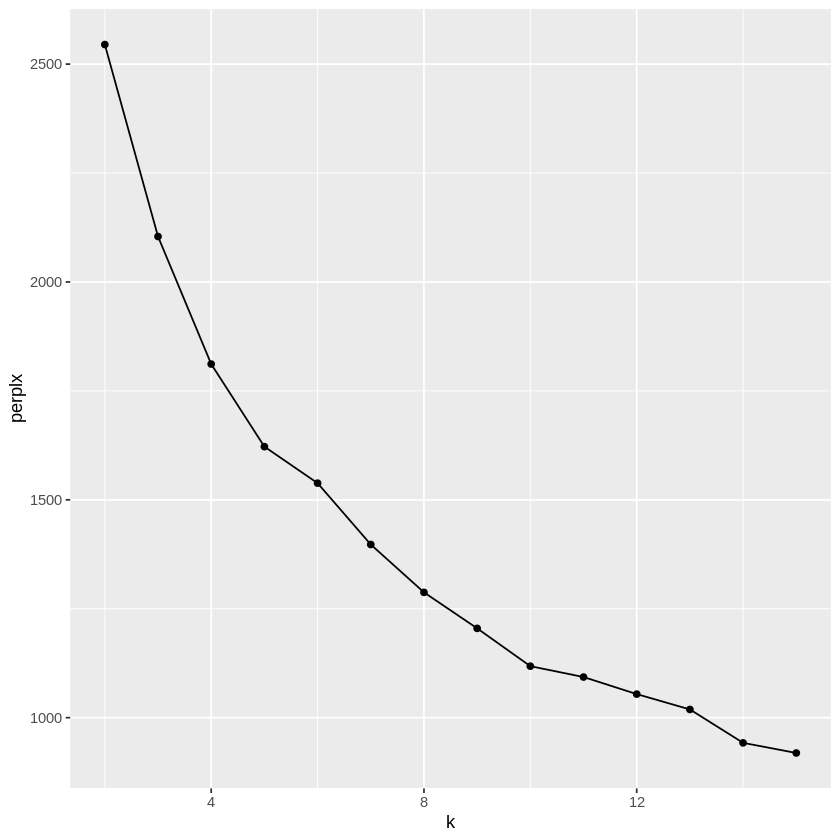

In [76]:
#Crianda o gráfico de perplexidade de acordo com o valor k (tópicos) variando de 2 a 15 por exemplo
#pode-se estimar o valor de k que represente ainda um ganho relevante com o aumento do número de tópicos 
k <- c(2:15)
perplx <- c()

for (i in k){
  lda <- LDA(mat_nosparse, k = i)
  perplx <- c(perplx, perplexity(lda, newdata = mat_nosparse))
}

ggplot() +
  geom_line(aes(x=k, y=perplx)) +
  geom_point(aes(x=k, y=perplx))

####Pela curva vê-se que até o valor de k igual a 5 tem-se uma queda da perplexidade acentuada, para em seguida diminuir um pouco a inclinação da curva até k igual a 7 e reduzindo mais fortemente a partir daí.

####Neste caso, iremos considerar o valor de k igual a 5 afim de não aumentar a complexidade da análise com um aumento de mais 2 tópicos.

####Além disso por termos capturado os textos do G1 com uma pré-identificação, tudo indica que o valor de 5 realmente pode ser a escolha mais adequada.


### Faça a análise dos tópicos criados com o número escolhido acima. Na sua análise apresente os termos mais importantes para cada tópico, nomeie cada tópico e apresente exemplos de documentos que se encaixem muito bem no tópico e outros que nem tanto. Pode adicionar outras informações que achar relevante para que o leitor entenda o que está acontecendo nos seus tópicos.



In [77]:
#Nomeando documentos
rownames(mat_nosparse) <- dados_final$document
lda <- LDA(mat_nosparse, k = 5, control = list(seed = 1234))
lda

A LDA_VEM topic model with 5 topics.

In [78]:
n_topics <- tidy(lda, matrix = "beta")

top_terms <- n_topics %>%
  group_by(topic) %>%
  top_n(5, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

terms(lda, 5)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
fundo,pena,saúde,universidade,segurança
amazônia,mensalão,universidade,educação,vírus
meio,dirceu,pessoas,estudantes,dados
alemanha,indulto,sarampo,brasil,site
florestas,prisão,enem,alunos,celular


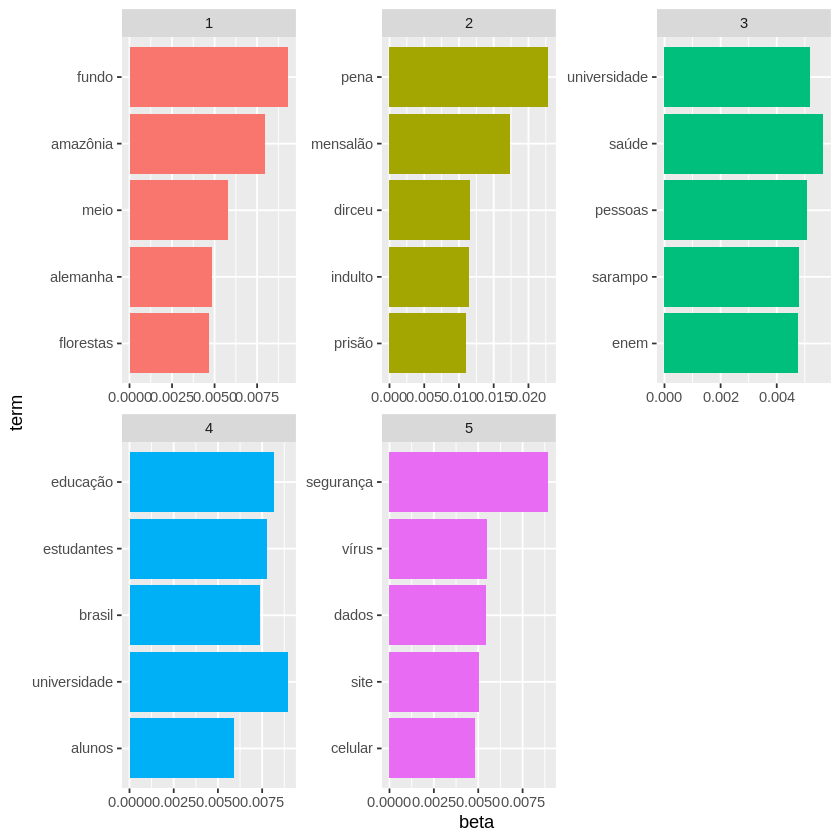

In [79]:
top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

###De acordo com o grupo de palavras principais fornecidas por tópico há uma tendência que sejam relacionados ao assuntos abaixo:

###* Tópico 1   - Natureza
###* Tópico 2   - Política
###* Tópico 3   - Ciência e Saúde
###* Tópico 4   - Educação
###* Tópico 5   - Tecnologia

Documentos por Tópico

Fonte,Indice,topic,gamma
<chr>,<int>,<int>,<dbl>
Fonte:Política,1,1,4.022675e-05
Fonte:Política,2,1,1.247131e-04
Fonte:Política,3,1,9.282454e-05
Fonte:Política,4,1,1.256945e-04
Fonte:Política,5,1,1.116386e-04
Fonte:Política,6,1,3.206962e-05
Fonte:Política,7,1,4.575811e-05
Fonte:Política,8,1,7.676492e-05
Fonte:Política,9,1,5.603073e-05


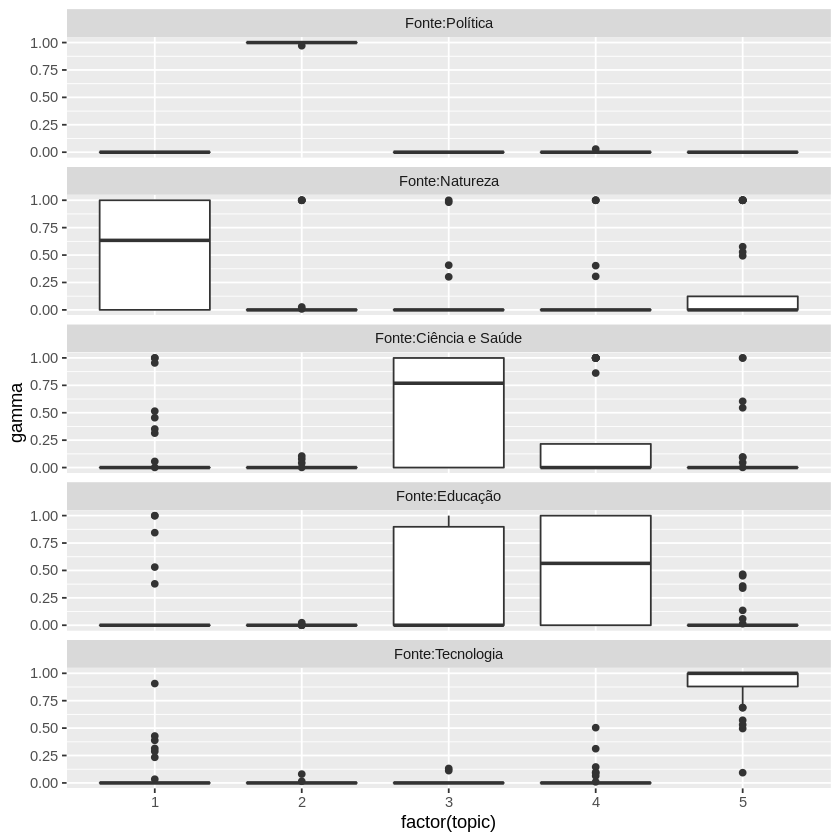

In [80]:
doc_gamma <- tidy(lda, matrix = "gamma")
doc_gamma <- doc_gamma %>% separate(document, c("Fonte", "Indice"), sep = "_", convert = TRUE)

doc_gamma

doc_gamma %>%
  mutate(title = reorder(Fonte, gamma * topic)) %>%
  ggplot(aes(factor(topic), gamma)) +
  geom_boxplot() +
  facet_wrap(~ title,ncol=1)

In [0]:
label_topicos <- c("Natureza","Política","Ciência e Saúde","Educação","Tecnologia")

In [127]:
# Fazendo a correlação entre os tópicos encontrados por documento
item_classifications <- doc_gamma %>%
  group_by(Fonte, Indice) %>%
  top_n(1, gamma) %>%
  ungroup()


colnames(item_classifications) <- c("Fonte", "Indice", "topics", "gamma")

head(item_classifications,n=20)



Fonte,Indice,topics,gamma
<chr>,<int>,<int>,<dbl>
Fonte:Educação,9,1,0.5303605
Fonte:Educação,10,1,0.9999078
Fonte:Educação,12,1,0.9985505
Fonte:Educação,40,1,0.8444311
Fonte:Ciência e Saúde,11,1,0.9998869
Fonte:Ciência e Saúde,32,1,0.9998154
Fonte:Ciência e Saúde,33,1,0.5145636
Fonte:Ciência e Saúde,39,1,0.9540304
Fonte:Natureza,1,1,0.9997849


In [128]:
doc_topics <- item_classifications
doc_topics <- count(doc_topics, vars=c('Fonte', 'topics')) %>%
  group_by(Fonte) %>%
  top_n(1, 4) %>%
  ungroup() %>%
  transmute(Consensus = label_topicos[topics], topics)  %>% distinct_all()

doc_topics


item_classifications_negativos <- item_classifications %>%
  inner_join(doc_topics, by = "topics") %>%
  filter(Fonte != paste0("Fonte:",Consensus))

item_classifications_positivos <- item_classifications %>%
  inner_join(doc_topics, by = "topics") %>%
  filter(Fonte == paste0("Fonte:",Consensus))

head(item_classifications_negativos,n = 50)

head(item_classifications_positivos,n = 50)

Consensus,topics
<chr>,<int>
Natureza,1
Ciência e Saúde,3
Educação,4
Tecnologia,5
Política,2


Fonte,Indice,topics,gamma,Consensus
<chr>,<int>,<int>,<dbl>,<chr>
Fonte:Educação,9,1,0.5303605,Natureza
Fonte:Educação,10,1,0.9999078,Natureza
Fonte:Educação,12,1,0.9985505,Natureza
Fonte:Educação,40,1,0.8444311,Natureza
Fonte:Ciência e Saúde,11,1,0.9998869,Natureza
Fonte:Ciência e Saúde,32,1,0.9998154,Natureza
Fonte:Ciência e Saúde,33,1,0.5145636,Natureza
Fonte:Ciência e Saúde,39,1,0.9540304,Natureza
Fonte:Tecnologia,38,1,0.9063341,Natureza


Fonte,Indice,topics,gamma,Consensus
<chr>,<int>,<int>,<dbl>,<chr>
Fonte:Natureza,1,1,0.9997849,Natureza
Fonte:Natureza,4,1,0.9998590,Natureza
Fonte:Natureza,5,1,0.9998975,Natureza
Fonte:Natureza,6,1,0.9996330,Natureza
Fonte:Natureza,8,1,0.9998170,Natureza
Fonte:Natureza,10,1,0.9998138,Natureza
Fonte:Natureza,14,1,0.9996082,Natureza
Fonte:Natureza,15,1,0.9996973,Natureza
Fonte:Natureza,16,1,0.5964115,Natureza


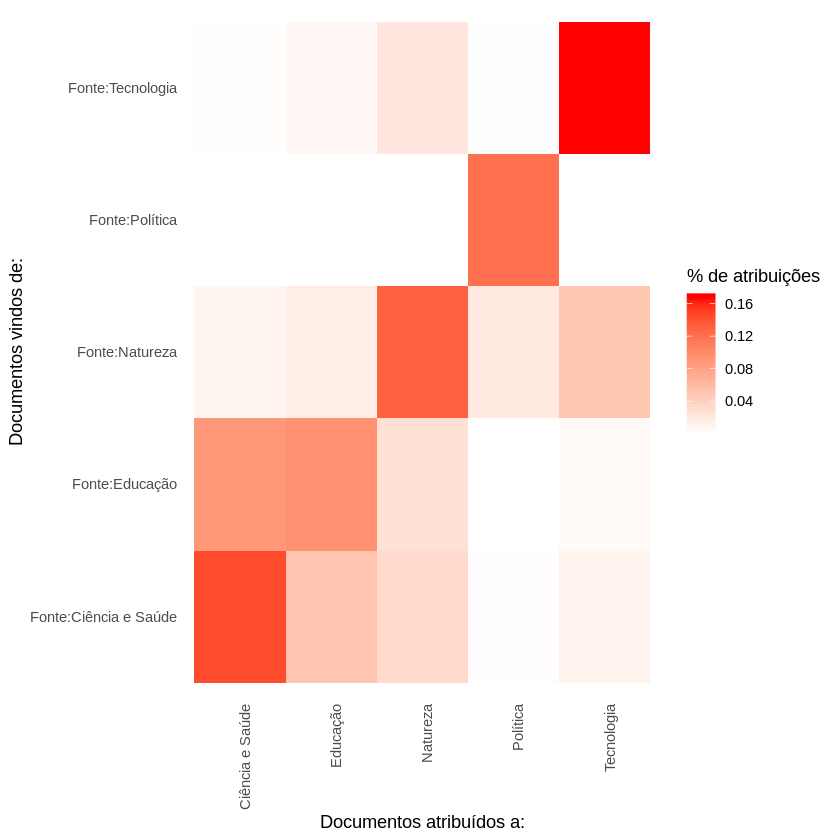

In [129]:
assignments <- augment(lda, data = mat_nosparse)
assignments <- assignments %>%
  separate(document, c("Fonte", "Indice"), sep = "_", convert = TRUE) %>%
  inner_join(doc_topics, by = c(".topic" = "topics"))

assignments <- count(assignments, vars=c('Fonte', 'Consensus')) %>%
  group_by(Fonte) %>%
  mutate(percent = freq / sum(freq)) %>%
  ggplot(aes(Consensus, Fonte, fill = percent)) +
  geom_tile() +
  scale_fill_gradient2(high = "red") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid = element_blank()) +
  labs(x = "Documentos atribuídos a:",
       y = "Documentos vindos de:",
       fill = "% de atribuições")
assignments

####Analisando as previsões de associação dos documentos aos tópicos e ao tema definido dos mesmos, vemos que a taxa de atribuição correta para os temas está bem elevada, tendo em vista que a diagonal do gráfico, que corresponde à correta atribuição, está com a cor mais forte.

####Documentos associados aos tópicos "Ciência e Saúde" e "Tecnologia", são os que mais obtiveram maior percentual de atribuições.







####A seguir listamos alguns documentos com atribuições corretas e outros com atribuições erroneamente atribuidas pelo modelo:

In [136]:
item_classifications_positivos$document <- paste0(item_classifications_positivos$Fonte,"_",item_classifications_positivos$Indice)

dados_final_1 <- dados_final

#Exemplos de identificações corretas
doc_positivo <- dados_final_1 %>%
  inner_join(item_classifications_positivos, by = "document") %>% select(document,Consensus,text)

head(doc_positivo,n=3)


document         Consensus
1 Fonte:Política_1 Política 
2 Fonte:Política_2 Política 
3 Fonte:Política_3 Política 
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [138]:

item_classifications_negativos$document <- paste0(item_classifications_negativos$Fonte,"_",item_classifications_negativos$Indice)
dados_final_2 <- dados_final

#Exemplos de identificações incorretas
doc_negativo <- dados_final_2 %>%
  inner_join(item_classifications_negativos, by = "document") %>% select(document,Consensus,text)

head(doc_negativo,n=3)

document         Consensus      
1 Fonte:Educação_6 Ciência e Saúde
2 Fonte:Educação_8 Ciência e Saúde
3 Fonte:Educação_9 Natureza       
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                